In [6]:
import numpy as np
import matplotlib.pyplot as plt

def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

P = getPositionEncoding(seq_len=4, d=4, n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]]


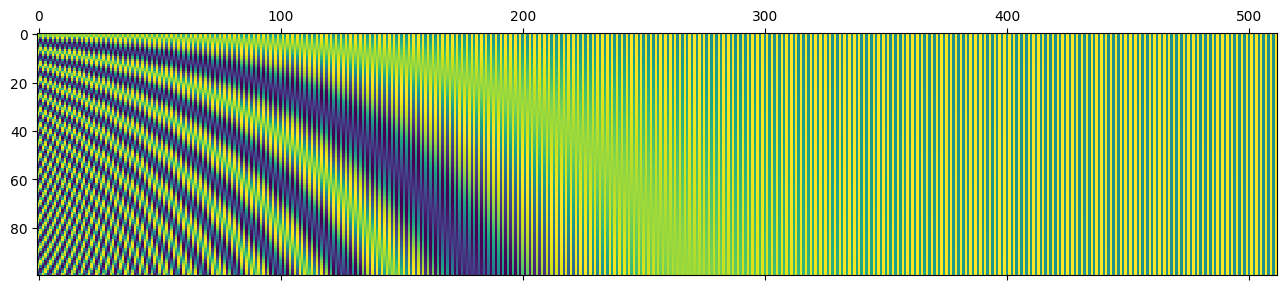

In [9]:
P = getPositionEncoding(100, 512, 10000)
plt.matshow(P)
plt.savefig("Positional Encoding.png")

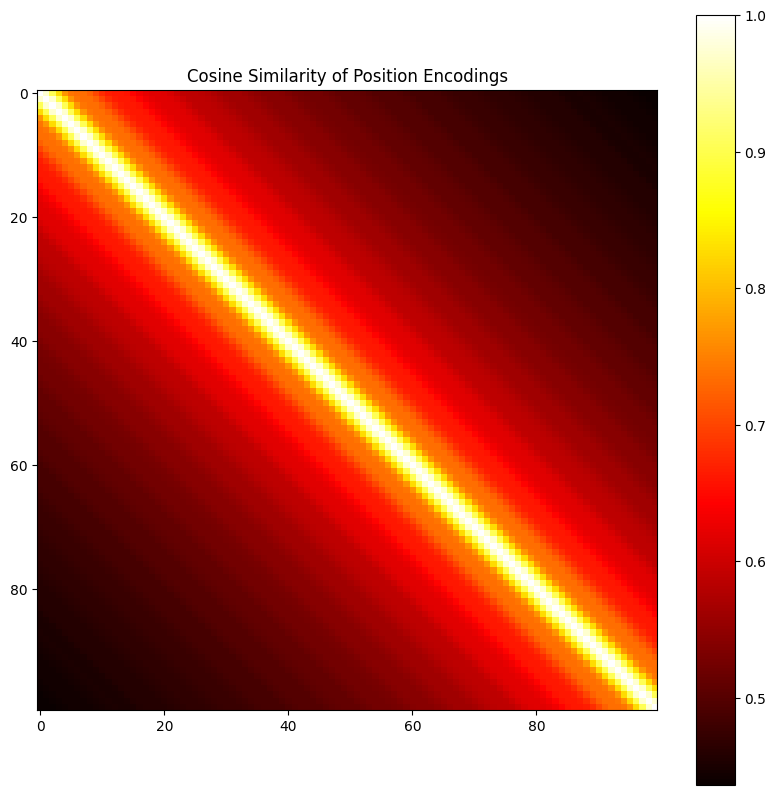

In [14]:
# 计算不同位置之间的余弦相似度
from scipy.spatial.distance import cosine

def compute_cosine_similarity(position_encodings):
    seq_len = position_encodings.shape[0]
    similarity_matrix = np.zeros((seq_len, seq_len))
    for i in range(seq_len):
        for j in range(seq_len):
            similarity_matrix[i, j] = 1 - cosine(position_encodings[i], position_encodings[j])
    return similarity_matrix

similarity_matrix = compute_cosine_similarity(P)
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.title('Cosine Similarity of Position Encodings')
plt.colorbar()
plt.savefig("Cosine Similarity of Position Encodings.png")
plt.show()


In [15]:
import os
import math
from typing import List

import torch
import matplotlib.pyplot as plt

os.environ['KMP_DUPLICATE_LIB_OK'] = "True"


def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)


def generate_qk(base: int, head_dim: int, max_position_embeddings: int = 2048):
    """生成 q、k 向量

    Args:
        base (int): base 值
        head_dim (int): 注意力头的维度
        max_position_embeddings (int, optional): 最大序列长度

    Returns:
        _type_: _description_
    """
    inv_freq = 1.0 / (base ** (torch.arange(0, head_dim, 2, dtype=torch.int64).float() / head_dim))
    t = torch.arange(max_position_embeddings, dtype=torch.int64).type_as(inv_freq)
    
    query_states = torch.ones((1, max_position_embeddings, 8, head_dim)).transpose(1, 2)
    key_states = torch.ones((1, max_position_embeddings, 8, head_dim)).transpose(1, 2)
    position_ids = torch.arange(0, max_position_embeddings, dtype=torch.int64).unsqueeze(0)
    
    inv_freq_expanded = inv_freq[None, :, None].float().expand(position_ids.shape[0], -1, 1)
    position_ids_expanded = position_ids[:, None, :].float()
    freqs = (inv_freq_expanded.float() @ position_ids_expanded.float()).transpose(1, 2)
    emb = torch.cat((freqs, freqs), dim=-1)
    cos = emb.cos()
    sin = emb.sin()
    cos = cos.unsqueeze(1)
    sin = sin.unsqueeze(1)
    q_embed = (query_states * cos) + (rotate_half(query_states) * sin)
    k_embed = (key_states * cos) + (rotate_half(key_states) * sin)
    
    return q_embed, k_embed


def get_matmul(base: int, max_position_embeddings: int) -> List:
    """获取注意力权重矩阵

    Args:
        base (int): base 值
        max_position_embeddings (int): 最大序列长度

    Returns:
        List: 注意力权重矩阵
    """
    q_embed, k_embed = generate_qk(
        base=base,
        head_dim=64,
        max_position_embeddings=max_position_embeddings
    )
    attn_weights = torch.matmul(q_embed, k_embed.transpose(2, 3)) / math.sqrt(64)
    return attn_weights[0][0][0].numpy().tolist()

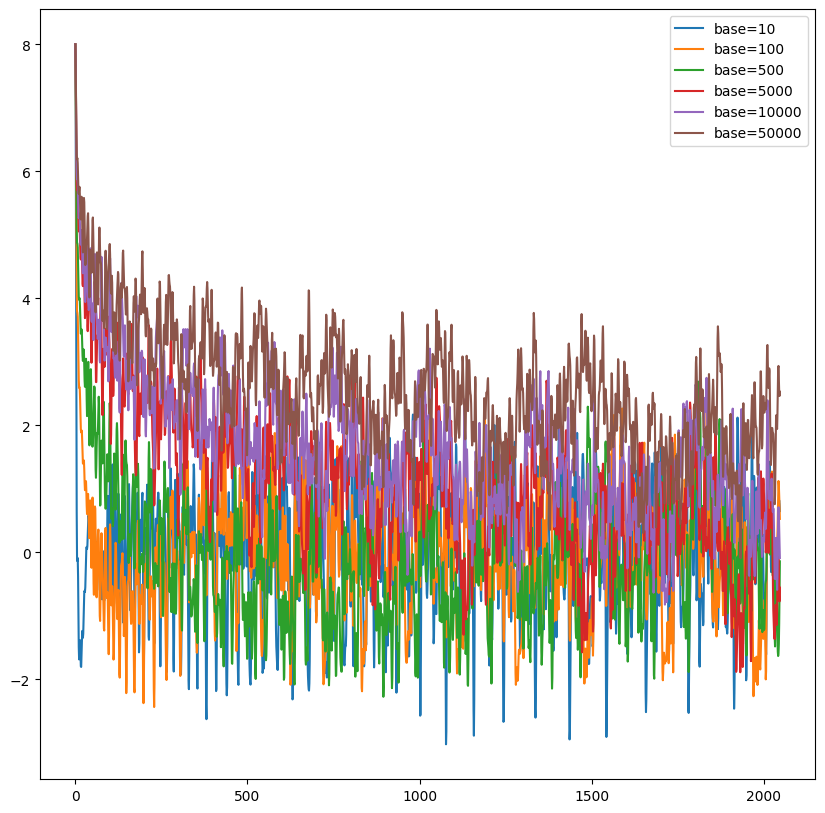

In [16]:
max_position_embeddings = 2048

y = get_matmul(1, max_position_embeddings)
y1 = get_matmul(10, max_position_embeddings)
y2 = get_matmul(100, max_position_embeddings)
y3 = get_matmul(500, max_position_embeddings)
y4 = get_matmul(5000, max_position_embeddings)
y5 = get_matmul(10000, max_position_embeddings)
y6 = get_matmul(50000, max_position_embeddings)
x = list(range(0, max_position_embeddings))

plt.rc("figure", figsize=(10, 10))
# plt.plot(x, y, label="base=1")
plt.plot(x, y1, label="base=10")
plt.plot(x, y2, label="base=100")
plt.plot(x, y3, label="base=500")
plt.plot(x, y4, label="base=5000")
plt.plot(x, y5, label="base=10000")
plt.plot(x, y6, label="base=50000")

# 添加图例
plt.legend()

# # 显示图形
plt.show()